In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def Nusselt(Re,Pr,externo=True):
    if externo:
        if Re < 10**5:
            return 0.664*Re**(1/2)*Pr**(1/3)
        else:
            return 0.037*(Re**(4/5)-871)*Pr**(1/3)
    else:
        if Re < 10**4:
            return 4.36
        else:
            return 0.023*Re**(4/5)*Pr**(1/3)

def Prandtl(nu,k_f,rho,c_p):
    alfa = k_f/(rho*c_p)
    return nu/alfa

def Reynolds(v,L,nu):
    return v*L/nu

def conveccion(nu,k_f,rho,c_p,v,L,externo=True):
    Re = Reynolds(v,L,nu)
    Pr = Prandtl(nu,k_f,rho,c_p)
    #print("Re = {:.2f}; --- Pr = {:.2f}".format(Re,Pr))
    
    Nu = Nusselt(Re,Pr,externo=externo)
    
    return k_f*Nu/L

def dimsAleta(N0,L_aleta,dens):
    N = N0/4
    delta_x= 2*L/N
    t = dens*delta_x
    d = delta_x*(1-dens)
    P = 2*(t+l)
    A_b = t*l
    A_0 = d*l
    A_f = P*L_aleta
    
    print('Número total de aletas = {}'.format(N0))
    print('Número de aletas por costado = {}'.format(N))
    print('Distancia entre aletas = {:.2f}'.format(d))
    print('Longitud de la aleta = {:.2f}'.format(L_aleta))
    print('Ancho de la aleta = {:.2f}'.format(t))
    
    return (P,A_0,A_b,A_f)

def conveccionAletas(h0,k,L_aleta,P,A_0,A_b,A_f):
    m = np.sqrt(h0*P/(k*A_b))
    eta = np.tanh(m*L_aleta)/(m*L_aleta)
    h_eq = eta*h0*A_f/A_b
    H_eq = (A_0*h0 + A_b*h_eq)/(A_0+A_b)
    
    return H_eq

In [3]:
def calcular():
    particion = 20
    ND = particion+1
    NumVariables = ND**2

    d = 1/particion
    
    # Matriz de coeficientes ------------------------------------------------------------------
    A = np.zeros((NumVariables,NumVariables))
    y = np.zeros(NumVariables) 

    # Lleno ecuaciones de nodos internos -----------------------------------------------------------
    for alfa in range(22,41): #el índice alfa recorre los nodos de izquierda a derecha
        for beta in 21*np.arange(0,19): #el índice beta recorre los nodos de arriba a abajo
            i = alfa+beta
            A[i,i] = -4
            A[i,i-1] = 1; A[i,i+1]=1; A[i,i-21]=1; A[i,i+21]=1

    # Llena los nodos (triviales) en el canal de refrigeración --------------------------------------------------
    for alfa in range(21*15+1,21*15+6): 
        for beta in 21*np.arange(0,5):
            i = alfa+beta
            A[i,i] = 1
            A[i,i-1] = 0; A[i,i+1]=0; A[i,i-21]=0; A[i,i+21]=0
            y[i] = th_i

    # Lleno ecuaciones de nodos de borde --------------------------------------------------------------
    for alfa in range(1,20): 
        i = alfa # recorre el borde superior
        A[i,i] = -2*(h_e*d + 2)
        A[i,i-1] = 1; A[i,i+1] = 1; A[i,i+21] = 2;

        i = 21*alfa # recorre el borde izquierdo (implementando condición de simetría)
        A[i,i] = -4
        A[i,i+1] = 2; A[i,i+21] = 1; A[i,i-21] = 1;

        i = 20 + 21*(alfa) #recorre el borde derecho
        A[i,i] = -2*(h_e*d + 2)
        A[i,i-1] = 2; A[i,i-21] = 1; A[i,i+21] = 1;

        i = 420 + alfa # recorre el borde inferior (implementando condición de simetría)
        A[i,i] = -4
        A[i,i-21] = 2; A[i,i-1] = 1; A[i,i+1] = 1;

    # Llena los nodos (triviales) en el canal de refrigeración ----------------------------------------------------------
    for alfa in range(0,5): 
        i = 21*15 + 21*alfa # recorre el borde izquierdo del canal
        A[i,i] = 1
        A[i,i+1] = 0; A[i,i+21] = 0; A[i,i-21] = 0;
        y[i] = th_i

        i = 21*20 + 1 + alfa #recorre el borde inferior del canal
        A[i,i] = 1
        A[i,i-21] = 0; A[i,i-1] = 0; A[i,i+1] = 0;
        y[i] = th_i


    # Llena los nodos en el borde del canal de refrigeración ----------------------------------------------------------
    for alfa in range(4): 
        i = 341 + 21*alfa # Recorre el borde derecho
        A[i,i] = -2*(h_i*d + 2)
        A[i,i-21] = 1; A[i,i+21] = 1; A[i,i+1] = 2
        y[i] = -2*h_i*d*th_i

        i = 21*15 + alfa+1 # Recorre el borde superior
        A[i,i] = -2*(h_i*d + 2)
        A[i,i-1] = 1; A[i,i+1] = 1; A[i,i-21] = 2
        y[i] = -2*h_i*d*th_i

    # Llena nodos restantes ----------------------------------------------------------------------

    A[0,0] = -2*(h_e*d + 2); A[0,1] = 2; A[0,21] = 2 # Nodo de borde externo con condición de simetría
    A[440,440] = -2*(h_e*d + 2); A[440,419] = 2; A[440,439] = 2 # Nodo de borde externo  con condición de simetría

    A[420,420] = 1; y[420] = th_i
    A[315,315] = -2*(h_i*d + 2); A[315,316] = 2; A[315,315-21] = 2 # Nodo de borde interno con condición de simetría
    A[425,425] = -2*(h_i*d + 2); A[425,404] = 2; A[425,426] = 2 # Nodo de borde interno con condición de simetría

    A[20,20] = -2*(h_e*d + 1); A[20,19] = 1; A[20,41] = 1 # Nodo de esquina

    # Nodo de esquina interna
    A[320,320] = -2*(3+h_i*d); A[320,320-1] = 1; A[320,320+1] = 2; A[320,320-21] = 2; A[320,320+21] = 1
    y[320] = -2*h_i*d*th_i

    # Asigna los nodos con generación de calor  --------------------------------------------------------------
    for alfa in range(21*5+10,21*5+16):
        for beta in 21*np.arange(0,6):
            i = alfa+beta
            y[i] = -q*d**2

            i = alfa+beta-10
            y[i] = -q*d**2

            i = alfa+beta + 210
            y[i] = -q*d**2

    # Solución ----------------------------------------------------------------
    thetas = np.matmul(np.linalg.inv(A),y)
    thetas2 = thetas.reshape((21,21))
    
    return thetas,thetas2

In [27]:
def graficar():
    # Mapa de calor --------------------------------------------------------------
    fig,ax = plt.subplots(figsize=(12,12))
    min_col = min(thetas[np.where(thetas!=0.)])/1.5
    mapa = ax.imshow(thetas2,cmap='RdYlBu_r',interpolation='gaussian',vmin=min_col,vmax=max(thetas)) #afmhot RdBu_r ,interpolation='gaussian'
    plt.ylim(21,-1)
    plt.xlim(0,20)
    plt.yticks(np.arange(21),np.round(1-np.arange(0,21)/20,decimals=2))
    plt.xticks(np.arange(21),np.arange(21)/20)
    plt.colorbar(mapa,fraction=0.043, pad=0.04)
    ax.grid()
    plt.title(r'Mapa de $\theta$*')

    # Líneas de contorno --------------------------------------------------------
    cat = np.sort(thetas[np.where(thetas!=0.)])[np.array(len(thetas[np.where(thetas!=0.)])/15*np.arange(1,15),dtype=int)]
    cont = ax.contour(thetas2,levels=cat,cmap='RdBu_r',vmin=min_col,vmax=max(thetas))
    ax.clabel(cont, inline=1, fontsize=9,colors='black')
    plt.show()


    Temp = thetas2*T_inf+T_inf
    Temp2 = thetas*T_inf+T_inf

    # Mapa de calor --------------------------------------------------------------
    fig,ax = plt.subplots(figsize=(12,12))
    min_col = min(thetas[np.where(thetas!=0.)])/1.5
    mapa = ax.imshow(Temp,cmap='RdYlBu_r',interpolation='gaussian') #afmhot RdBu_r ,interpolation='gaussian'
    plt.ylim(21,-1)
    plt.xlim(0,20)
    plt.yticks(np.arange(21),np.round(1-np.arange(0,21)/20,decimals=2))
    plt.xticks(np.arange(21),np.arange(21)/20)
    plt.colorbar(mapa,fraction=0.043, pad=0.04)
    ax.grid()
    plt.title('Mapa de Temperaturas. T_max = {:.2f}'.format(np.max(Temp2)))

    # Líneas de contorno --------------------------------------------------------
    cat = np.sort(Temp2[np.where(thetas!=0.)])[np.array(len(thetas[np.where(thetas!=0.)])/10*np.arange(1,10),dtype=int)]
    cont = ax.contour(Temp,levels=cat,cmap='RdBu_r')
    ax.clabel(cont, inline=1, fontsize=9,colors='black')
    plt.show()

In [28]:
# Condiciones impuestas -------------------------------------------------------
Q = 60*10**3 # Watts
T_max = 500 #°C

# Condiciones de la pieza ----------------------------------------------------
k_pieza = 5 # W/(m°C)
L = 0.6 # metros
l = 2 # metros

A_gen = (0.25*L)**2
A_cond = (0.5*L)**2
P_cond = 4*(0.5*L)
q_vol = Q/(A_gen*l)/12
D = 4*A_cond/P_cond

# Condiciones de flujo externo -----------------------------------------------
T_inf = 25 # °C
v_a = 5 # m/s
k_a = 0.026 # W/(m°C)
rho_a = 1.2 # kg/m^3
nu_a = 1.1516e-5 # m^2/s
cP_a = 1.006e3 #J/kg

In [29]:
# Condiciones de flujo interno ----------------------------------------------
T_entrada = 25 #°C
v_f = 0.6 # m/s

# Agua
k_f = 0.5918 # W/(m°C)
rho_f = 998 # kg/m^3
nu_f = 1.004e-6 # m^2/s
cP_f = 4.186e3 #J/kg
k_f = 0.58 # W/(m°C)

# # Amonio líquido 753
# k_f = 0.55 # W/(m°C)
# rho_f = 0.73 # kg/m^3
# nu_f = 13.8e-6 # m^2/s
# cP_f = 4650 #J/kg

# # Etilenglicol 651
# k_f = 0.43 # W/(m°C)
# rho_f = 1110 # kg/m^3
# nu_f = 1.78e-5 # m^2/s
# cP_f = 3297 #J/kg

# # R407C 635
# k_f = 0.09113 # W/(m°C)
# rho_f = 1134 # kg/m^3
# nu_f = 0.000212/rho_f # m^2/s
# cP_f = 1540 #J/kg

# #r134a 640
# k_f = 0.08113 # W/(m°C)
# rho_f = 1206 # kg/m^3
# nu_f = 0.000202/rho_f # m^2/s
# cP_f = 1510 #J/kg

# # r22 640
# k_f = 0.0868 # W/(m°C)
# rho_f = 1190 # kg/m^3
# nu_f = 0.000178/rho_f # m^2/s
# cP_f = 1260 #J/kg

Caudal = v_f*A_cond
m_punto = Q*rho_f
T_s = Q/(m_punto*cP_f) + T_entrada

Temperatura máxima del refrigerante: 25.0 °C
Caudal: 0.054 m^3/s


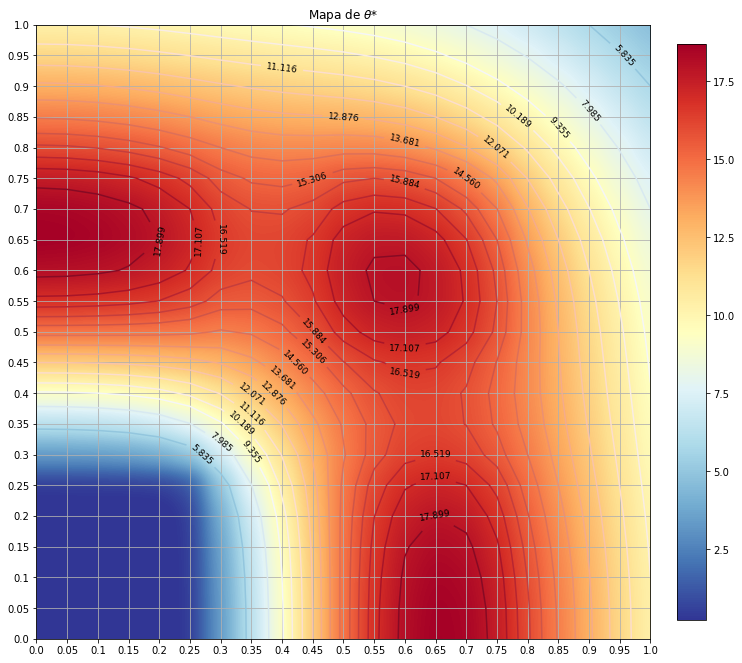

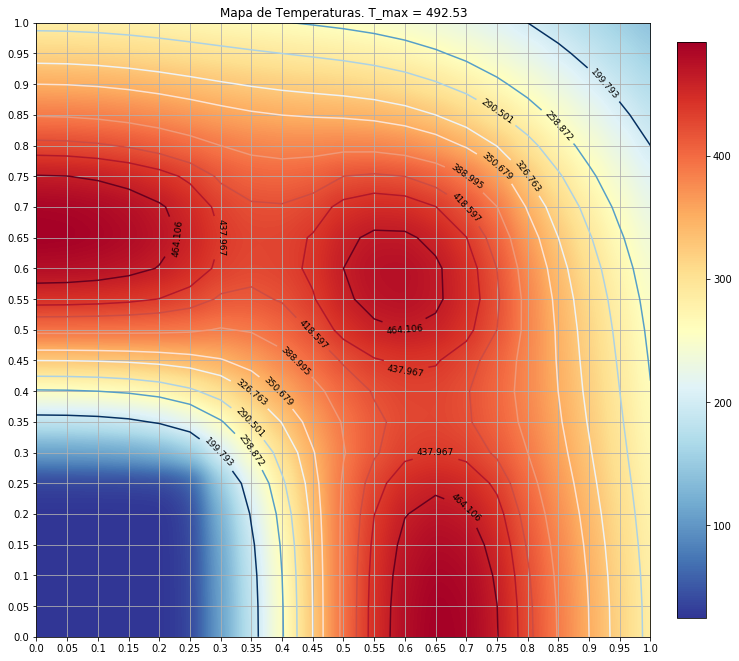

In [32]:
# Variables adimensionales ------------------------------------------------------
h_e = conveccion(nu_a,k_a,rho_a,cP_a,v_a,l,externo=True)*L/k_pieza
h_i = conveccion(nu_f,k_f,rho_f,cP_f,v_f,D,externo=False)*L/k_pieza
q = q_vol*L**2/(k_pieza*T_inf)
th_i = 0

print('Temperatura máxima del refrigerante: {:.1f} °C'.format(T_s))
print('Caudal: {:.3f} m^3/s'.format(Caudal))

thetas,thetas2 = calcular()

graficar()

Número total de aletas = 20
Número de aletas por costado = 5.0
Distancia entre aletas = 0.12
Longitud de la aleta = 0.08
Ancho de la aleta = 0.12


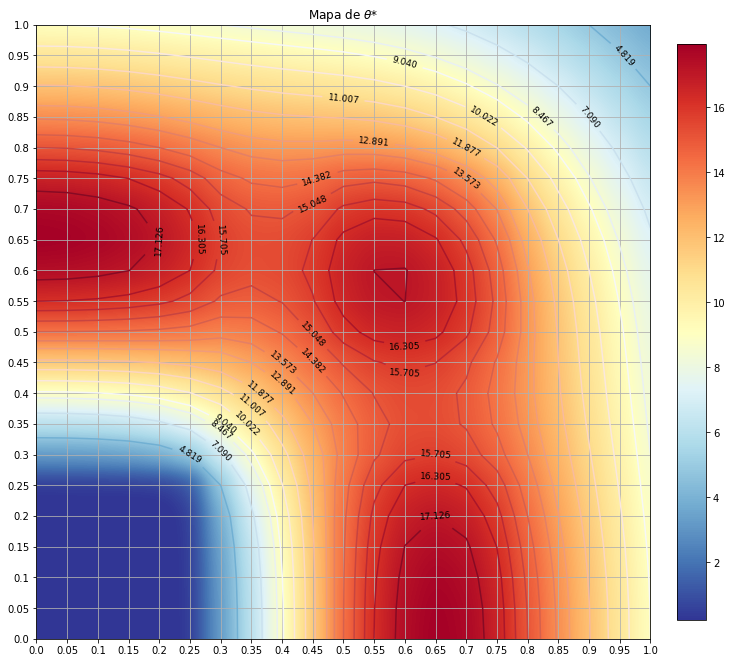

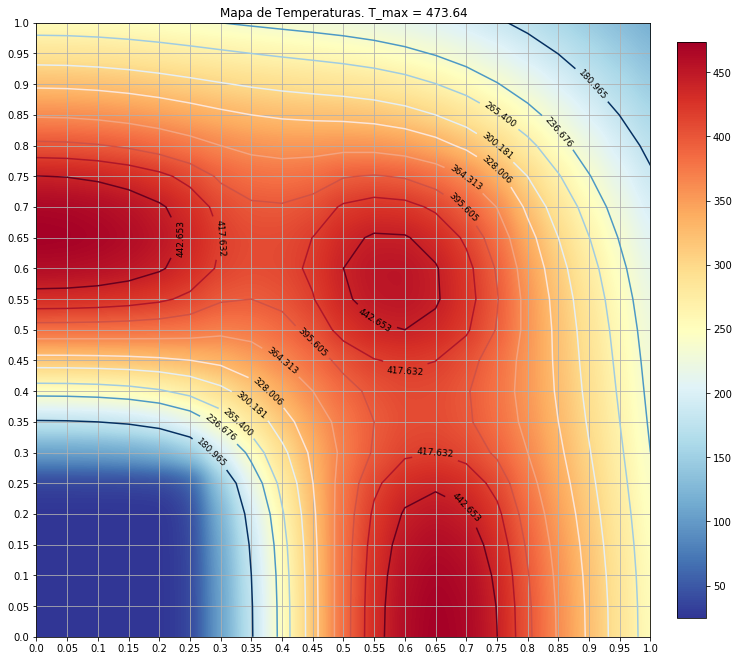

In [33]:
(N0,L_aleta,dens) = (20,0.08,0.5)
(P,A_0,A_b,A_f) = dimsAleta(N0,L_aleta,dens)
H_eq = conveccionAletas(h_e,k_pieza,L_aleta,P,A_0,A_b,A_f)

h_e = H_eq
thetas,thetas2 = calcular()

graficar()